
<h2> Named Entity Recognition (NER) using LSTMs with Keras</h2>

###Project Overview and Import Modules

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.2.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


###Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [ ]:
data['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [ ]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [ ]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Retrieve Sentences and Corresponsing Tags

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
getter.grouped

Sentence #
Sentence: 1        [(Thousands, NNS, O), (of, IN, O), (demonstrat...
Sentence: 10       [(Iranian, JJ, B-gpe), (officials, NNS, O), (s...
Sentence: 100      [(Helicopter, NN, O), (gunships, NNS, O), (Sat...
Sentence: 1000     [(They, PRP, O), (left, VBD, O), (after, IN, O...
Sentence: 10000    [(U.N., NNP, B-geo), (relief, NN, O), (coordin...
                                         ...                        
Sentence: 9995     [(Opposition, NNP, O), (leader, NN, O), (Mir, ...
Sentence: 9996     [(On, IN, O), (Thursday, NNP, B-tim), (,, ,, O...
Sentence: 9997     [(Following, VBG, O), (Iran, NNP, B-geo), ('s,...
Sentence: 9998     [(Since, IN, O), (then, RB, O), (,, ,, O), (au...
Sentence: 9999     [(The, DT, O), (United, NNP, B-org), (Nations,...
Length: 47959, dtype: object

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define Mappings between Sentences and Tags

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
list(word2idx.keys())[-2]

'Newsweek'

### Padding Input Sentences and Creating Train/Test Splits

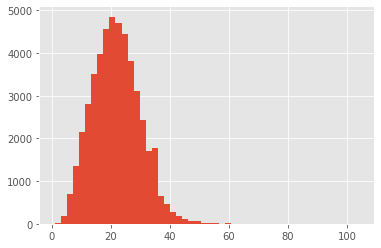

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
max([len(s) for s in sentences])

104

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 104
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
X[0]

array([34849,  3405, 12228, 29103,  9402,  1660,  5985,  4476, 24588,
       22039, 14124, 23657, 19923, 16066, 14091, 22039,  6984,  3405,
        1970, 11377, 26348, 31432, 13241,  4173, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Build and Compile a Bidirectional LSTM Model

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=64, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 104)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 104, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          132000    
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           3417      
Total params: 2,386,873
Trainable params: 2,386,873
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Train the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=64, 
    epochs=3,
    callbacks = callbacks
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9705
Epoch 00001: val_loss improved from inf to 0.05589, saving model to model_weights.h5
600/600 [==============================] - 391s 651ms/step - loss: 0.1510 - accuracy: 0.9705 - val_loss: 0.0559 - val_accuracy: 0.9854
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9901
Epoch 00002: val_loss improved from 0.05589 to 0.02983, saving model to model_weights.h5
600/600 [==============================] - 388s 646ms/step - loss: 0.0360 - accuracy: 0.9901 - val_loss: 0.0298 - val_accuracy: 0.9917
Epoch 3/3
600/600 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9935
Epoch 00003: val_loss improved from 0.02983 to 0.02621, saving model to model_weights.h5
600/600 [==============================] - 383s 639ms/step - loss: 0.0226 - accuracy: 0.9935 - val_loss: 0.0262 - val_accuracy: 0.9924


### Task 8: Evaluate Named Entity Recognition Model

In [ ]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 15s 51ms/step - loss: 0.0262 - accuracy: 0.9924


[0.02620711736381054, 0.9924225807189941]

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
center         O	O
is             O	O
urging         O	O
Jamaica        B-geo	B-geo
and            O	O
the            O	O
Cayman         B-org	B-org
Islands        I-org	I-org
to             O	O
monitor        O	O
the            O	O
threats        O	O
posed          O	O
by             O	O
Ernesto        B-org	B-per
,              O	O
the            O	O
fifth          O	O
named          O	O
storm          O	O
of             O	O
the            O	O
season         O	O
.              O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O	O
Newsweek       O